In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import os
import gc
import pickle

from skimage.filters import gaussian
from skimage.morphology import remove_small_objects
from scipy.ndimage import center_of_mass
from csbdeep.utils import normalize
from skimage.segmentation import clear_border
from skimage import feature
import scipy.stats

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [25]:
dataDir='/data/xzhang/neuro'
phenoLabels=['Control','AD','FTLD-TDPC','PSP','IPD']
tif3dpath='TIFS/3DOrig'
segPath='TIFS/segmentations'
stains=['GFAP','MAP2','LMNB','DAPI']
proj2dpath='TIFS/2DMaxProj/2DMaxProj'

In [6]:
import utils.plot

#### stats on 2D proj

In [7]:
savedir_processed=os.path.join(dataDir,'processed')

with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
with open(os.path.join(savedir_processed,'allCoord'), 'rb') as output:
    allCoord=pickle.load(output)
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientID=pickle.load(output)
with open(os.path.join(savedir_processed,'allCat'), 'rb') as output:
    allCat=pickle.load(output)

In [48]:
imgStats_clf=pd.DataFrame(index=np.unique(allImgNames))


In [49]:
#cell density
sname,sidx_start,scounts=np.unique(allImgNames,return_index=True,return_counts=True)
sarea=np.zeros(sname.size)
for i in range(sname.size):
    allCoord_i=allCoord[allImgNames==sname[i]]
    sarea[i]=(np.max(allCoord_i[:,0])-np.min(allCoord_i[:,0]))*(np.max(allCoord_i[:,1])-np.min(allCoord_i[:,1]))
scounts_norm=scounts/sarea

imgStats_clf['cell density']=scounts_norm

In [13]:
scounts

array([2886, 1004, 1412, 2022, 2827, 2466, 1456, 1254, 1408,  315,  342,
       2364, 1827, 1169, 4300, 3049, 1533, 1758, 1471, 1611, 1205,  967,
       1908, 2519, 2200, 1992,  449,  362, 1705, 1763, 1735,  691,  945,
        128, 1350, 1687, 1670, 1653,  337,  306,  302, 1407, 1670, 1674,
        488, 1759, 1606, 2259, 2078, 2375, 1667, 2462, 3063, 1084, 1424,
       1931, 2107, 1612,  984, 2238,  269,  195,  567,  263])

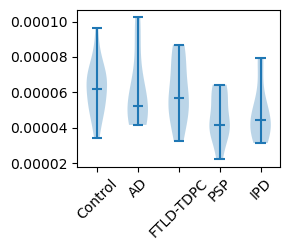

In [21]:
cdensityRes={}
for p in phenoLabels:
    cdensityRes[p]=[]
for i in range(sname.size):
    cdensityRes[allCat[sidx_start[i]]].append(scounts_norm[i])

fig,ax=plt.subplots(figsize=(3,2.6))
plt.violinplot(list(cdensityRes.values()), showmeans=False, showextrema=True, showmedians=True)
plt.xticks(range(1, len(cdensityRes) + 1), cdensityRes.keys(),rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(savedir_processed,'cellDensity.pdf'))
plt.show()

In [ ]:
#co-occurance matrix
newbatchID=['P10-20-1','P10-20-2','P16-19-1','P16-19-2','P33-18-1','P33-18-2','P38-19-1','P38-19-2','P38-19-3','P49-18-1','P49-18-2','P49-18-3','P85-19-1','P85-19-2','P89-19-1','P89-19-2']

minmaxScale=(10,99.99)
maxIntensity=255

pmtx_dapi={}
pmtx_gfap={}
pmtx_map2={}
pmtx_lmnb={}

pmtx_dapi_snames={}
pmtx_gfap_snames={}
pmtx_map2_snames={}
pmtx_lmnb_snames={}

distances=[1,4,16,64,128]
angles=[0,np.pi/4,np.pi/2]

for p in phenoLabels:
    print(p)
    pmtx_dapi[p]=[]
    pmtx_gfap[p]=[]
    pmtx_lmnb[p]=[]
    pmtx_map2[p]=[]
    
    pmtx_dapi_snames[p]=[]
    pmtx_gfap_snames[p]=[]
    pmtx_lmnb_snames[p]=[]
    pmtx_map2_snames[p]=[]
    
#     for s in os.listdir(os.path.join(dataDir,p,proj2dpath)):
    for s in os.listdir(os.path.join(dataDir,p,proj2dpath,'DAPI')):
        print(s)
        #load 2d dapi
        img2d=io.imread(os.path.join(dataDir,p,proj2dpath,'DAPI',s))
        img2d[img2d<np.percentile(img2d,minmaxScale[0])]=np.percentile(img2d,minmaxScale[0])
        img2d=(img2d-np.min(img2d))/(np.max(img2d)-np.min(img2d))*maxIntensity
        img2d=img2d.astype(int)
        #load 2d gfap
        img2d_gfap=io.imread(os.path.join(dataDir,p,proj2dpath,'GFAP',s))
        img2d_gfap[img2d_gfap<np.percentile(img2d_gfap,minmaxScale[0])]=np.percentile(img2d_gfap,minmaxScale[0])
        img2d_gfap=(img2d_gfap-np.min(img2d_gfap))/(np.max(img2d_gfap)-np.min(img2d_gfap))*maxIntensity
        img2d_gfap=img2d_gfap.astype(int)
        #load 2d map2
        img2d_map2=io.imread(os.path.join(dataDir,p,proj2dpath,'MAP2',s))
        img2d_map2[img2d_map2<np.percentile(img2d_map2,minmaxScale[0])]=np.percentile(img2d_map2,minmaxScale[0])
        img2d_map2=(img2d_map2-np.min(img2d_map2))/(np.max(img2d_map2)-np.min(img2d_map2))*maxIntensity
        img2d_map2=img2d_map2.astype(int)
        #load 2d lmnb
        img2d_lmnb=io.imread(os.path.join(dataDir,p,proj2dpath,'LMNB',s))
        img2d_lmnb[img2d_lmnb<np.percentile(img2d_lmnb,minmaxScale[0])]=np.percentile(img2d_lmnb,minmaxScale[0])
        img2d_lmnb=(img2d_lmnb-np.min(img2d_lmnb))/(np.max(img2d_lmnb)-np.min(img2d_lmnb))*maxIntensity
        img2d_lmnb=img2d_lmnb.astype(int)
        
        pmtx_dapi[p].append(feature.graycomatrix(img2d,distances,angles,levels=maxIntensity+1))
        pmtx_gfap[p].append(feature.graycomatrix(img2d_gfap,distances,angles,levels=maxIntensity+1))
        pmtx_map2[p].append(feature.graycomatrix(img2d_map2,distances,angles,levels=maxIntensity+1))
        pmtx_lmnb[p].append(feature.graycomatrix(img2d_lmnb,distances,angles,levels=maxIntensity+1))
        
        pmtx_dapi_snames[p].append(s)
        pmtx_gfap_snames[p].append(s)
        pmtx_map2_snames[p].append(s)
        pmtx_lmnb_snames[p].append(s)

In [51]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('DAPI')
            prop_all=[]
            prop_all_names=[]
            
            for p in phenoLabels:
                for sidx in range(len(pmtx_dapi[p])):
                    prop_all.append(feature.graycoprops(pmtx_dapi[p][sidx],prop)[didx,aidx])
                    prop_all_names.append(pmtx_dapi_snames[p][sidx][:-4])
            imgStats_clf.loc[prop_all_names,'dapi_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all
                 
        

homogeneity
distance:  1
angle:  0
DAPI
homogeneity
distance:  1
angle:  0.7853981633974483
DAPI
homogeneity
distance:  1
angle:  1.5707963267948966
DAPI
homogeneity
distance:  4
angle:  0
DAPI
homogeneity
distance:  4
angle:  0.7853981633974483
DAPI
homogeneity
distance:  4
angle:  1.5707963267948966
DAPI
homogeneity
distance:  16
angle:  0
DAPI
homogeneity
distance:  16
angle:  0.7853981633974483
DAPI
homogeneity
distance:  16
angle:  1.5707963267948966
DAPI
homogeneity
distance:  64
angle:  0
DAPI
homogeneity
distance:  64
angle:  0.7853981633974483
DAPI
homogeneity
distance:  64
angle:  1.5707963267948966
DAPI
homogeneity
distance:  128
angle:  0
DAPI
homogeneity
distance:  128
angle:  0.7853981633974483
DAPI
homogeneity
distance:  128
angle:  1.5707963267948966
DAPI
correlation
distance:  1
angle:  0
DAPI
correlation
distance:  1
angle:  0.7853981633974483
DAPI
correlation
distance:  1
angle:  1.5707963267948966
DAPI
correlation
distance:  4
angle:  0
DAPI
correlation
distance:  4

In [52]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('map2')
            prop_all=[]
            prop_all_names=[]
            
            for p in phenoLabels:
                for sidx in range(len(pmtx_map2[p])):
                    prop_all.append(feature.graycoprops(pmtx_map2[p][sidx],prop)[didx,aidx])
                    prop_all_names.append(pmtx_map2_snames[p][sidx][:-4])
            imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all
                 
        

homogeneity
distance:  1
angle:  0
map2
homogeneity
distance:  1
angle:  0.7853981633974483
map2
homogeneity
distance:  1
angle:  1.5707963267948966
map2
homogeneity
distance:  4
angle:  0
map2
homogeneity
distance:  4
angle:  0.7853981633974483
map2
homogeneity
distance:  4
angle:  1.5707963267948966
map2
homogeneity
distance:  16
angle:  0
map2
homogeneity
distance:  16
angle:  0.7853981633974483
map2
homogeneity
distance:  16
angle:  1.5707963267948966
map2
homogeneity
distance:  64
angle:  0
map2
homogeneity
distance:  64
angle:  0.7853981633974483
map2
homogeneity
distance:  64
angle:  1.5707963267948966
map2
homogeneity
distance:  128
angle:  0
map2
homogeneity
distance:  128
angle:  0.7853981633974483
map2
homogeneity
distance:  128
angle:  1.5707963267948966
map2
correlation
distance:  1
angle:  0
map2
correlation
distance:  1
angle:  0.7853981633974483
map2
correlation
distance:  1
angle:  1.5707963267948966
map2
correlation
distance:  4
angle:  0
map2
correlation
distance:  4

/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  0
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  0
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  0
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  0
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  0
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  0
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  0.7853981633974483
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  1.5707963267948966
map2


/tmp/ipykernel_2945656/3562283471.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'map2_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


In [53]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('gfap')
            prop_all=[]
            prop_all_names=[]
            
            for p in phenoLabels:
                for sidx in range(len(pmtx_gfap[p])):
                    prop_all.append(feature.graycoprops(pmtx_gfap[p][sidx],prop)[didx,aidx])
                    prop_all_names.append(pmtx_gfap_snames[p][sidx][:-4])
            imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all
                 
        

homogeneity
distance:  1
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  1
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  1
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  4
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  4
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  4
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  16
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  16
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  16
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  64
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  64
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  64
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  128
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  128
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  128
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  1
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  1
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  1
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  4
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  4
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  4
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  16
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  16
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  16
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  64
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  64
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  64
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  128
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  128
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  128
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  1
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  1
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  1
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  4
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  4
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  4
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  16
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  16
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  16
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  0
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  0.7853981633974483
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  1.5707963267948966
gfap


/tmp/ipykernel_2945656/513246628.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'gfap_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


In [54]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('lmnb')
            prop_all=[]
            prop_all_names=[]
            
            for p in phenoLabels:
                for sidx in range(len(pmtx_lmnb[p])):
                    prop_all.append(feature.graycoprops(pmtx_lmnb[p][sidx],prop)[didx,aidx])
                    prop_all_names.append(pmtx_lmnb_snames[p][sidx][:-4])
            imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all
                 
        

homogeneity
distance:  1
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  1
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  1
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  4
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  4
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  4
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  16
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  16
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  16
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  64
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  64
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  64
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  128
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  128
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


homogeneity
distance:  128
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  1
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  1
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  1
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  4
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  4
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  4
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  16
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  16
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  16
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  64
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  64
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  64
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  128
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  128
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


correlation
distance:  128
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  1
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  1
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  1
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  4
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  4
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  4
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  16
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  16
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  16
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  64
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


ASM
distance:  128
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  1
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  4
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  16
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  64
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  0
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  0.7853981633974483
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


contrast
distance:  128
angle:  1.5707963267948966
lmnb


/tmp/ipykernel_2945656/1412937635.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imgStats_clf.loc[prop_all_names,'lmnb_'+prop+'_dist'+str(distances[didx])+'_a'+str(angles[aidx])]=prop_all


In [57]:
imgStats_clf=imgStats_clf.copy()

In [59]:
imgStats_clf.to_csv(os.path.join(savedir_processed,'imgStats_clf.csv'))

In [32]:
os.mkdir(os.path.join(savedir_processed,'plots'))

homogeneity
distance:  1
angle:  0
DAPI


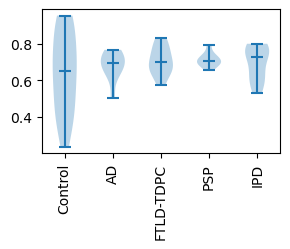

homogeneity
distance:  1
angle:  0.7853981633974483
DAPI


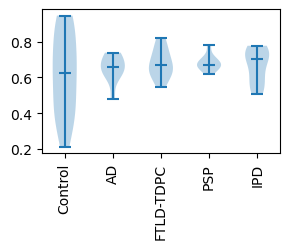

homogeneity
distance:  1
angle:  1.5707963267948966
DAPI


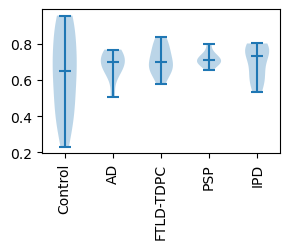

homogeneity
distance:  4
angle:  0
DAPI


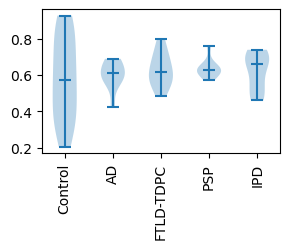

homogeneity
distance:  4
angle:  0.7853981633974483
DAPI


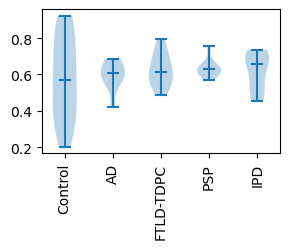

homogeneity
distance:  4
angle:  1.5707963267948966
DAPI


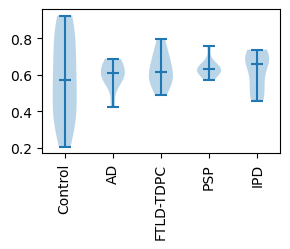

homogeneity
distance:  16
angle:  0
DAPI


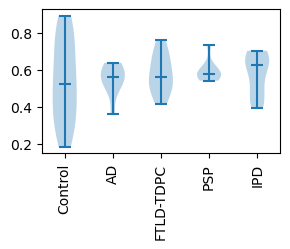

homogeneity
distance:  16
angle:  0.7853981633974483
DAPI


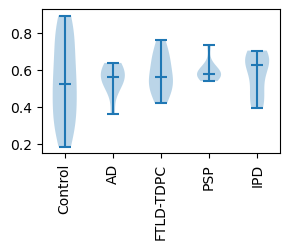

homogeneity
distance:  16
angle:  1.5707963267948966
DAPI


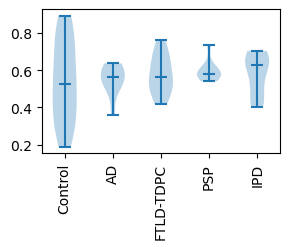

homogeneity
distance:  64
angle:  0
DAPI


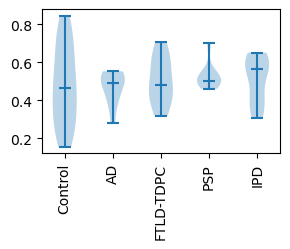

homogeneity
distance:  64
angle:  0.7853981633974483
DAPI


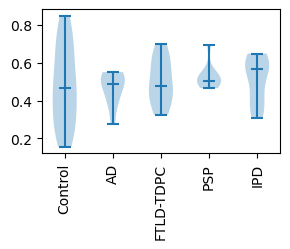

homogeneity
distance:  64
angle:  1.5707963267948966
DAPI


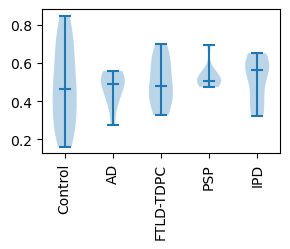

homogeneity
distance:  128
angle:  0
DAPI


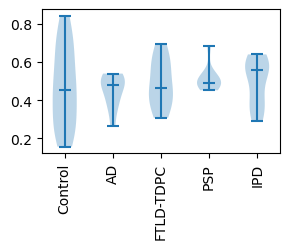

homogeneity
distance:  128
angle:  0.7853981633974483
DAPI


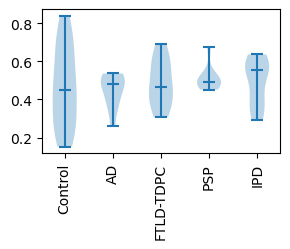

homogeneity
distance:  128
angle:  1.5707963267948966
DAPI


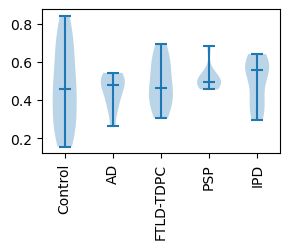

correlation
distance:  1
angle:  0
DAPI


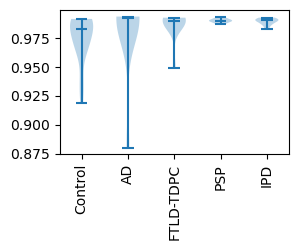

correlation
distance:  1
angle:  0.7853981633974483
DAPI


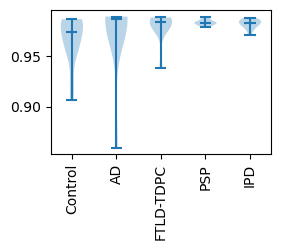

correlation
distance:  1
angle:  1.5707963267948966
DAPI


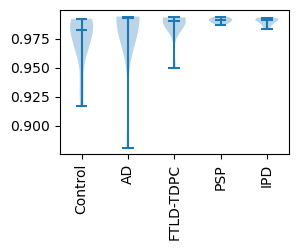

correlation
distance:  4
angle:  0
DAPI


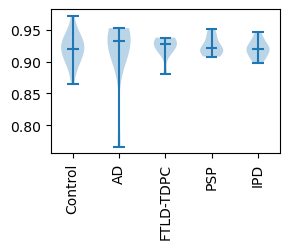

correlation
distance:  4
angle:  0.7853981633974483
DAPI


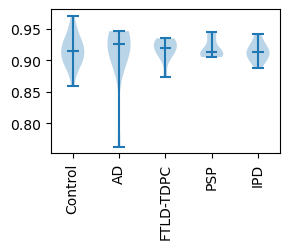

correlation
distance:  4
angle:  1.5707963267948966
DAPI


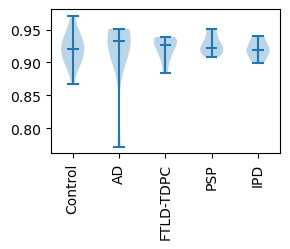

correlation
distance:  16
angle:  0
DAPI


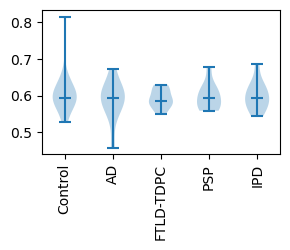

correlation
distance:  16
angle:  0.7853981633974483
DAPI


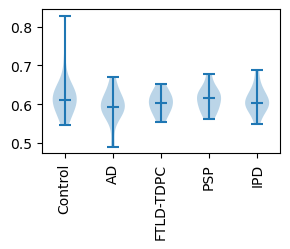

correlation
distance:  16
angle:  1.5707963267948966
DAPI


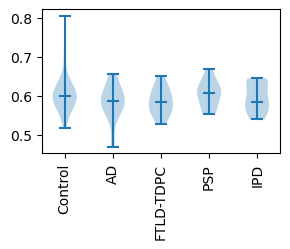

correlation
distance:  64
angle:  0
DAPI


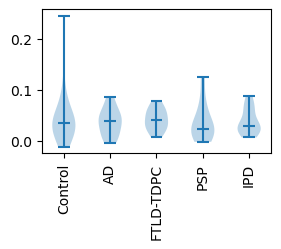

correlation
distance:  64
angle:  0.7853981633974483
DAPI


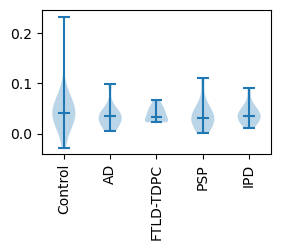

correlation
distance:  64
angle:  1.5707963267948966
DAPI


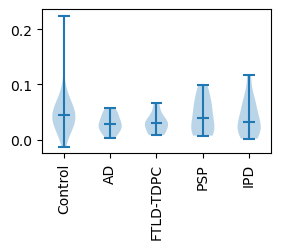

correlation
distance:  128
angle:  0
DAPI


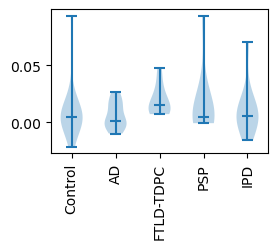

correlation
distance:  128
angle:  0.7853981633974483
DAPI


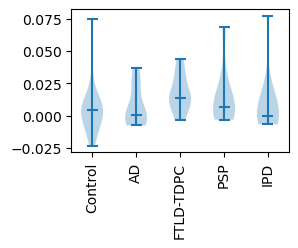

correlation
distance:  128
angle:  1.5707963267948966
DAPI


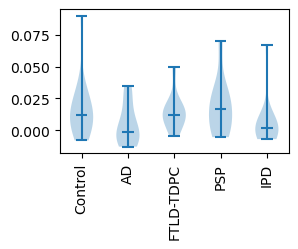

ASM
distance:  1
angle:  0
DAPI


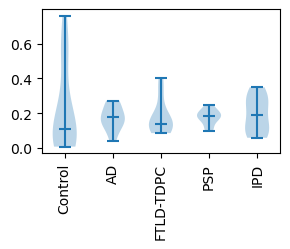

ASM
distance:  1
angle:  0.7853981633974483
DAPI


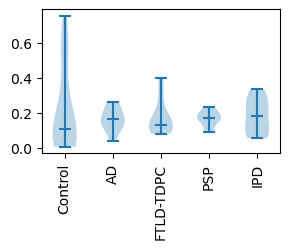

ASM
distance:  1
angle:  1.5707963267948966
DAPI


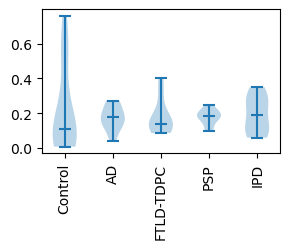

ASM
distance:  4
angle:  0
DAPI


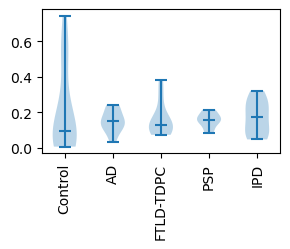

ASM
distance:  4
angle:  0.7853981633974483
DAPI


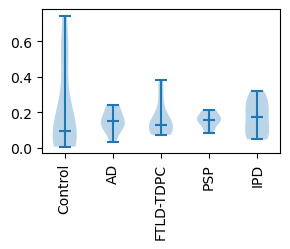

ASM
distance:  4
angle:  1.5707963267948966
DAPI


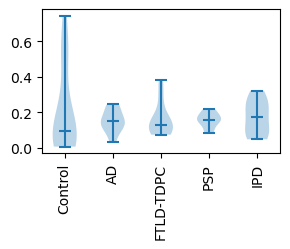

ASM
distance:  16
angle:  0
DAPI


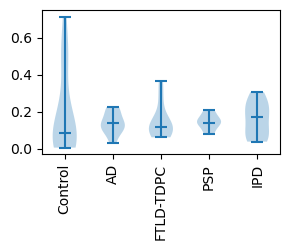

ASM
distance:  16
angle:  0.7853981633974483
DAPI


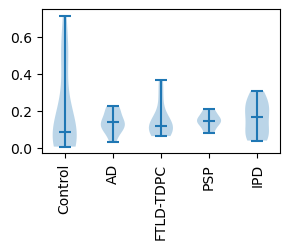

ASM
distance:  16
angle:  1.5707963267948966
DAPI


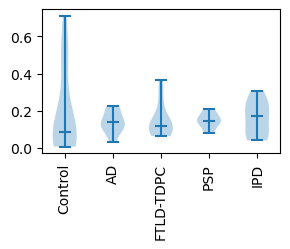

ASM
distance:  64
angle:  0
DAPI


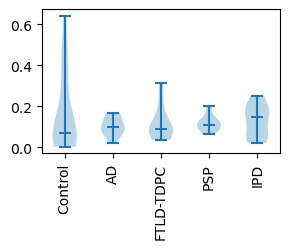

ASM
distance:  64
angle:  0.7853981633974483
DAPI


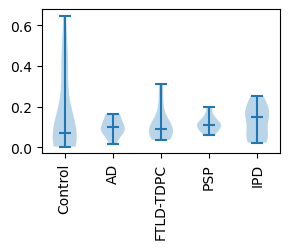

ASM
distance:  64
angle:  1.5707963267948966
DAPI


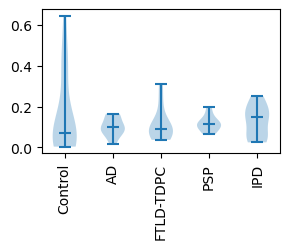

ASM
distance:  128
angle:  0
DAPI


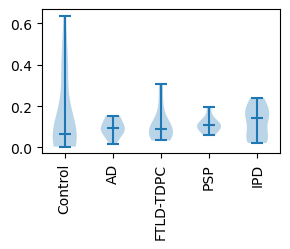

ASM
distance:  128
angle:  0.7853981633974483
DAPI


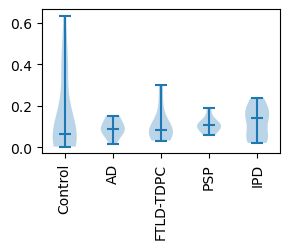

ASM
distance:  128
angle:  1.5707963267948966
DAPI


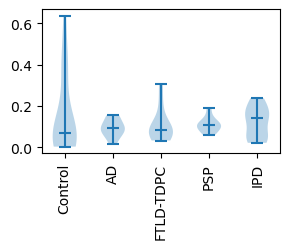

contrast
distance:  1
angle:  0
DAPI


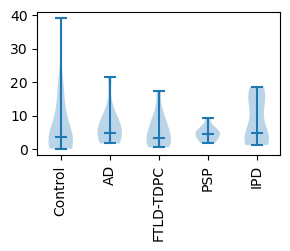

contrast
distance:  1
angle:  0.7853981633974483
DAPI


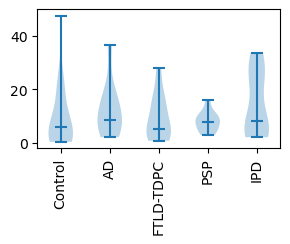

contrast
distance:  1
angle:  1.5707963267948966
DAPI


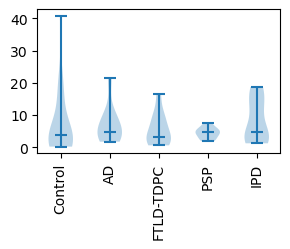

contrast
distance:  4
angle:  0
DAPI


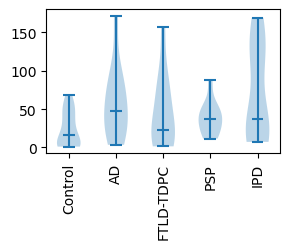

contrast
distance:  4
angle:  0.7853981633974483
DAPI


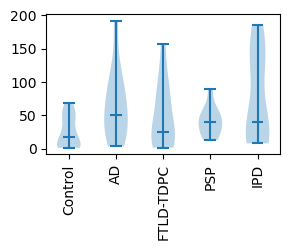

contrast
distance:  4
angle:  1.5707963267948966
DAPI


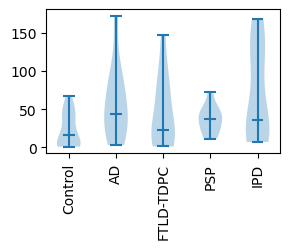

contrast
distance:  16
angle:  0
DAPI


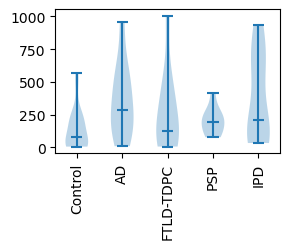

contrast
distance:  16
angle:  0.7853981633974483
DAPI


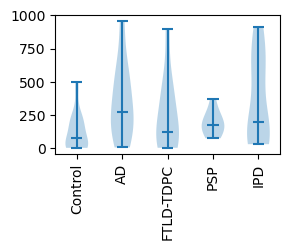

contrast
distance:  16
angle:  1.5707963267948966
DAPI


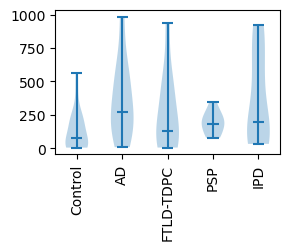

contrast
distance:  64
angle:  0
DAPI


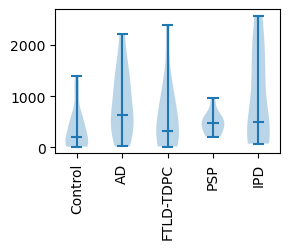

contrast
distance:  64
angle:  0.7853981633974483
DAPI


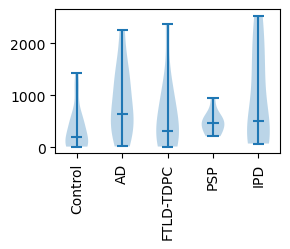

contrast
distance:  64
angle:  1.5707963267948966
DAPI


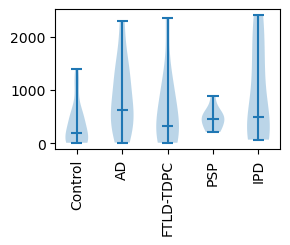

contrast
distance:  128
angle:  0
DAPI


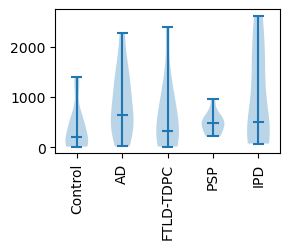

contrast
distance:  128
angle:  0.7853981633974483
DAPI


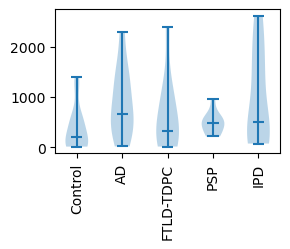

contrast
distance:  128
angle:  1.5707963267948966
DAPI


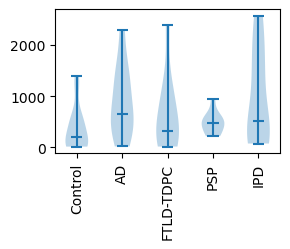

In [33]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('DAPI')
            prop_all={}
            for p in phenoLabels:
                prop_all[p]=[]
                for sidx in range(len(pmtx_dapi[p])):
                    prop_all[p].append(feature.graycoprops(pmtx_dapi[p][sidx],prop)[didx,aidx])
            
                 
            fig,ax=plt.subplots(figsize=(3,2.6))
            plt.violinplot(list(prop_all.values()), showmeans=False, showextrema=True, showmedians=True)
            plt.xticks(range(1, len(prop_all) + 1), prop_all.keys(),rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(savedir_processed,'plots',prop+'_dist'+str(distances[didx])+'_angle'+str(angles[aidx])+'_dapi.pdf'))
            plt.show()
            
        

homogeneity
distance:  1
angle:  0
gfap


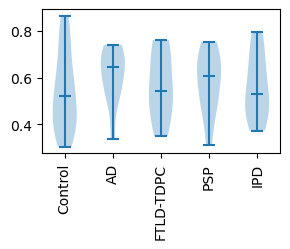

homogeneity
distance:  1
angle:  0.7853981633974483
gfap


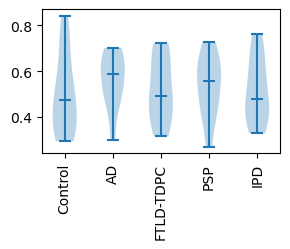

homogeneity
distance:  1
angle:  1.5707963267948966
gfap


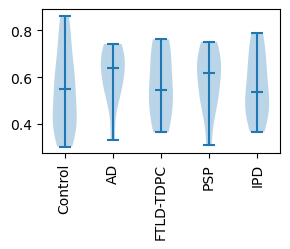

homogeneity
distance:  4
angle:  0
gfap


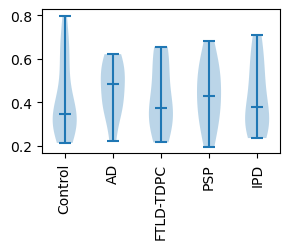

homogeneity
distance:  4
angle:  0.7853981633974483
gfap


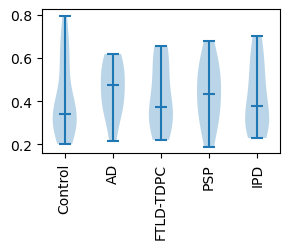

homogeneity
distance:  4
angle:  1.5707963267948966
gfap


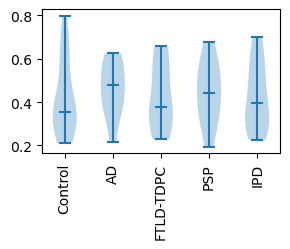

homogeneity
distance:  16
angle:  0
gfap


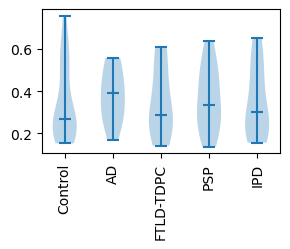

homogeneity
distance:  16
angle:  0.7853981633974483
gfap


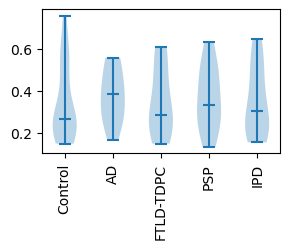

homogeneity
distance:  16
angle:  1.5707963267948966
gfap


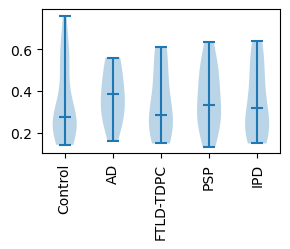

homogeneity
distance:  64
angle:  0
gfap


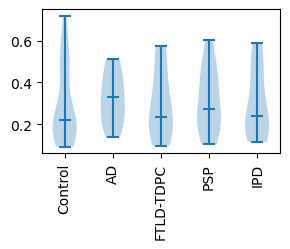

homogeneity
distance:  64
angle:  0.7853981633974483
gfap


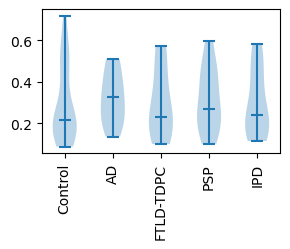

homogeneity
distance:  64
angle:  1.5707963267948966
gfap


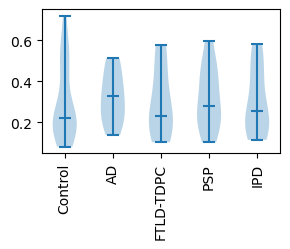

homogeneity
distance:  128
angle:  0
gfap


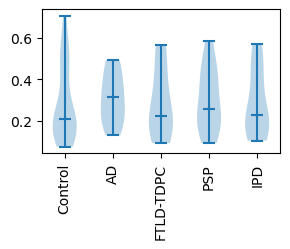

homogeneity
distance:  128
angle:  0.7853981633974483
gfap


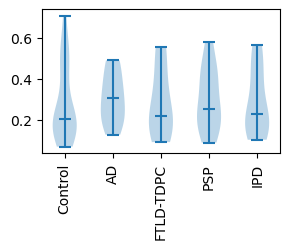

homogeneity
distance:  128
angle:  1.5707963267948966
gfap


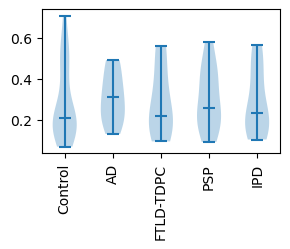

correlation
distance:  1
angle:  0
gfap


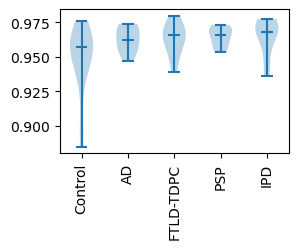

correlation
distance:  1
angle:  0.7853981633974483
gfap


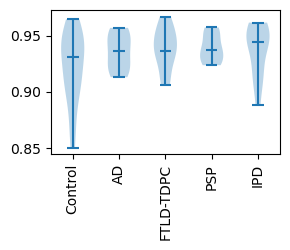

correlation
distance:  1
angle:  1.5707963267948966
gfap


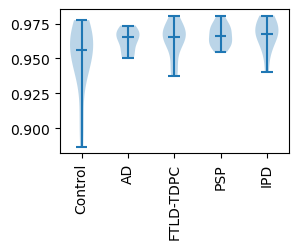

correlation
distance:  4
angle:  0
gfap


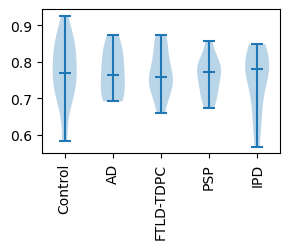

correlation
distance:  4
angle:  0.7853981633974483
gfap


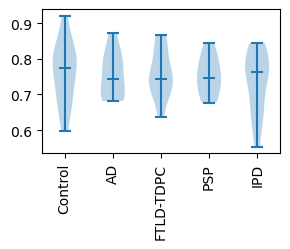

correlation
distance:  4
angle:  1.5707963267948966
gfap


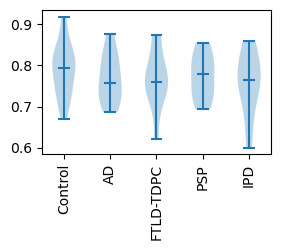

correlation
distance:  16
angle:  0
gfap


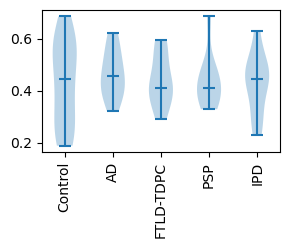

correlation
distance:  16
angle:  0.7853981633974483
gfap


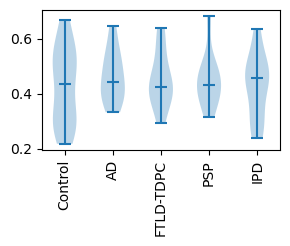

correlation
distance:  16
angle:  1.5707963267948966
gfap


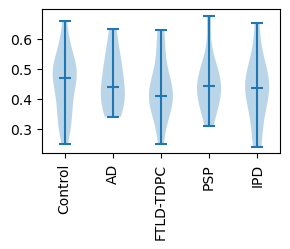

correlation
distance:  64
angle:  0
gfap


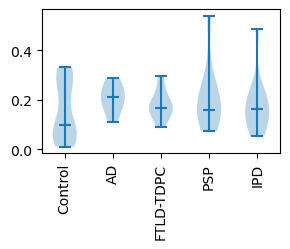

correlation
distance:  64
angle:  0.7853981633974483
gfap


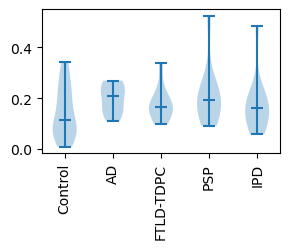

correlation
distance:  64
angle:  1.5707963267948966
gfap


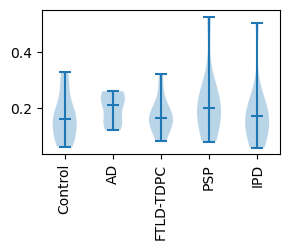

correlation
distance:  128
angle:  0
gfap


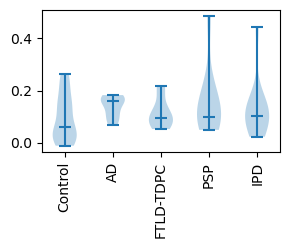

correlation
distance:  128
angle:  0.7853981633974483
gfap


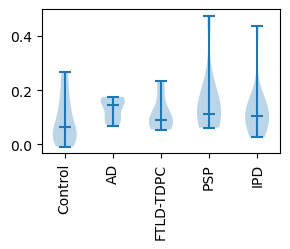

correlation
distance:  128
angle:  1.5707963267948966
gfap


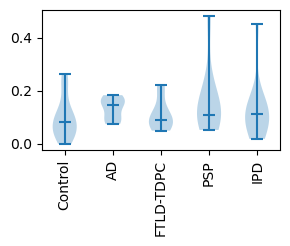

ASM
distance:  1
angle:  0
gfap


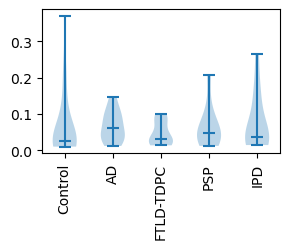

ASM
distance:  1
angle:  0.7853981633974483
gfap


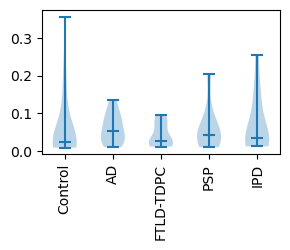

ASM
distance:  1
angle:  1.5707963267948966
gfap


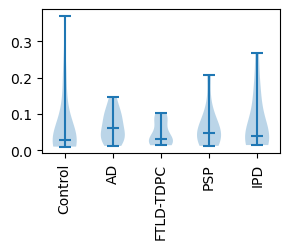

ASM
distance:  4
angle:  0
gfap


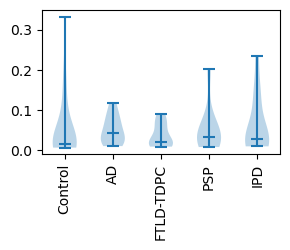

ASM
distance:  4
angle:  0.7853981633974483
gfap


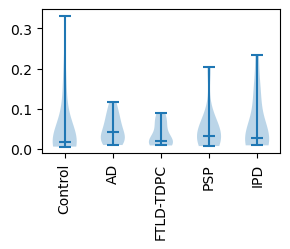

ASM
distance:  4
angle:  1.5707963267948966
gfap


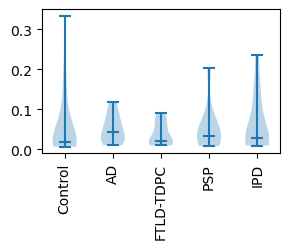

ASM
distance:  16
angle:  0
gfap


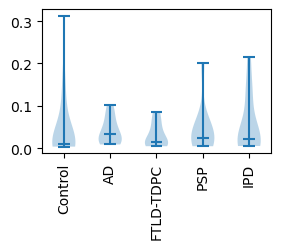

ASM
distance:  16
angle:  0.7853981633974483
gfap


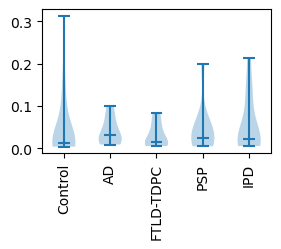

ASM
distance:  16
angle:  1.5707963267948966
gfap


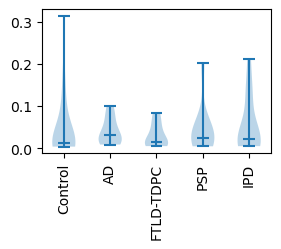

ASM
distance:  64
angle:  0
gfap


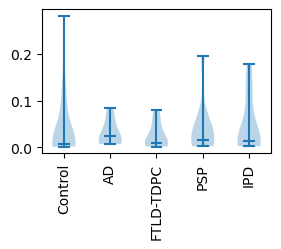

ASM
distance:  64
angle:  0.7853981633974483
gfap


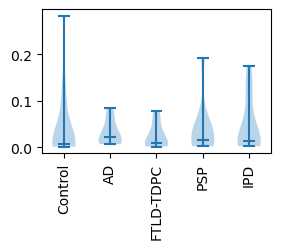

ASM
distance:  64
angle:  1.5707963267948966
gfap


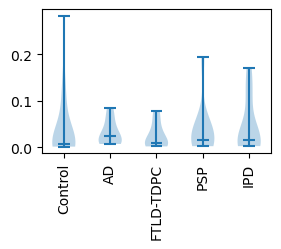

ASM
distance:  128
angle:  0
gfap


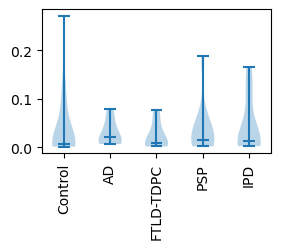

ASM
distance:  128
angle:  0.7853981633974483
gfap


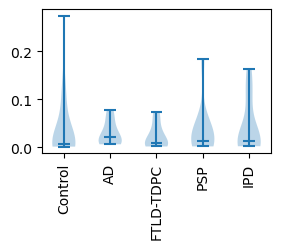

ASM
distance:  128
angle:  1.5707963267948966
gfap


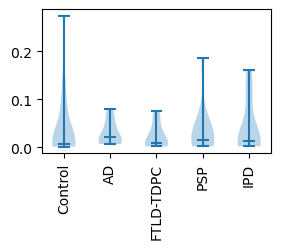

contrast
distance:  1
angle:  0
gfap


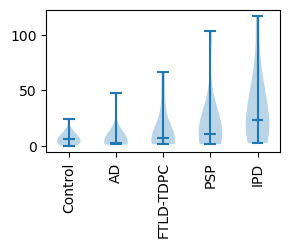

contrast
distance:  1
angle:  0.7853981633974483
gfap


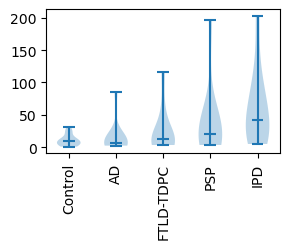

contrast
distance:  1
angle:  1.5707963267948966
gfap


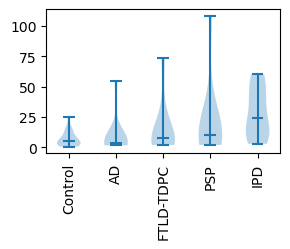

contrast
distance:  4
angle:  0
gfap


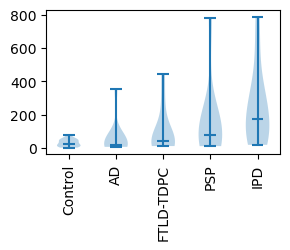

contrast
distance:  4
angle:  0.7853981633974483
gfap


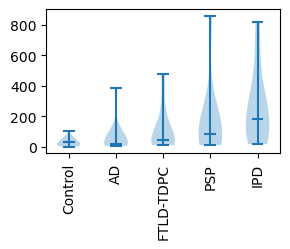

contrast
distance:  4
angle:  1.5707963267948966
gfap


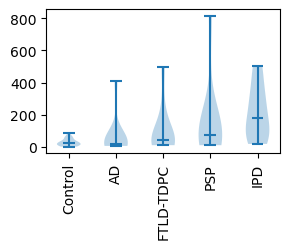

contrast
distance:  16
angle:  0
gfap


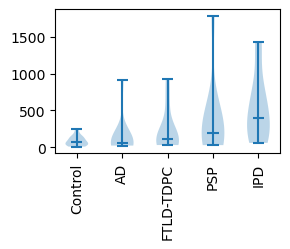

contrast
distance:  16
angle:  0.7853981633974483
gfap


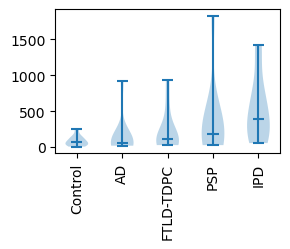

contrast
distance:  16
angle:  1.5707963267948966
gfap


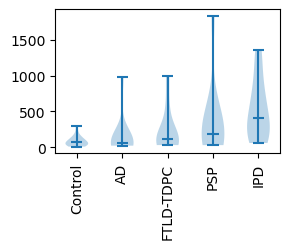

contrast
distance:  64
angle:  0
gfap


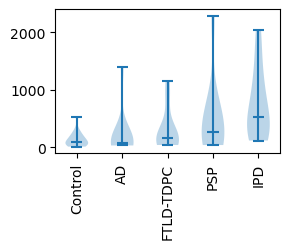

contrast
distance:  64
angle:  0.7853981633974483
gfap


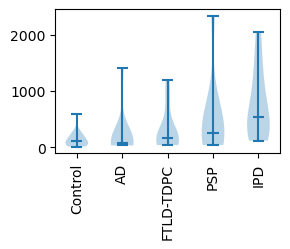

contrast
distance:  64
angle:  1.5707963267948966
gfap


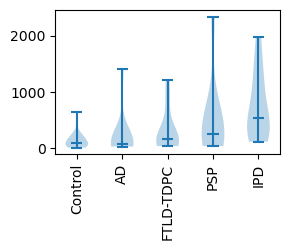

contrast
distance:  128
angle:  0
gfap


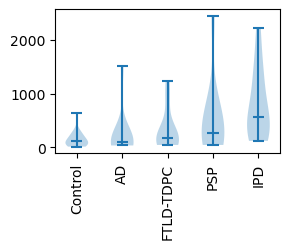

contrast
distance:  128
angle:  0.7853981633974483
gfap


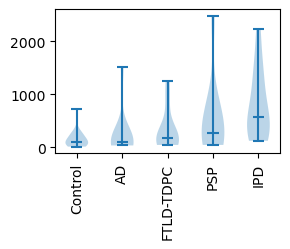

contrast
distance:  128
angle:  1.5707963267948966
gfap


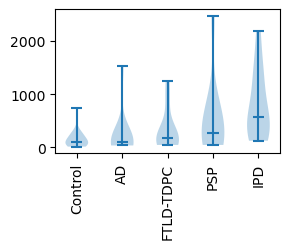

In [34]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('gfap')
            prop_all={}
            for p in phenoLabels:
                prop_all[p]=[]
                for sidx in range(len(pmtx_gfap[p])):
                    prop_all[p].append(feature.graycoprops(pmtx_gfap[p][sidx],prop)[didx,aidx])
            
                 
            fig,ax=plt.subplots(figsize=(3,2.6))
            plt.violinplot(list(prop_all.values()), showmeans=False, showextrema=True, showmedians=True)
            plt.xticks(range(1, len(prop_all) + 1), prop_all.keys(),rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(savedir_processed,'plots',prop+'_dist'+str(distances[didx])+'_angle'+str(angles[aidx])+'_gfap.pdf'))
            plt.show()
            
        

homogeneity
distance:  1
angle:  0
map2


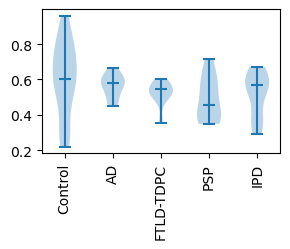

homogeneity
distance:  1
angle:  0.7853981633974483
map2


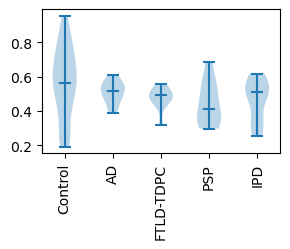

homogeneity
distance:  1
angle:  1.5707963267948966
map2


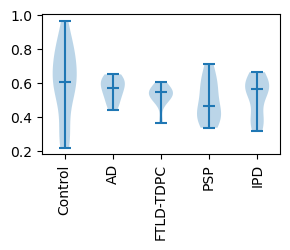

homogeneity
distance:  4
angle:  0
map2


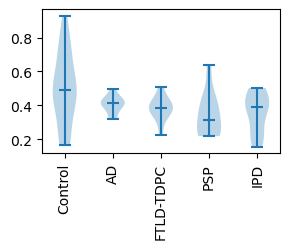

homogeneity
distance:  4
angle:  0.7853981633974483
map2


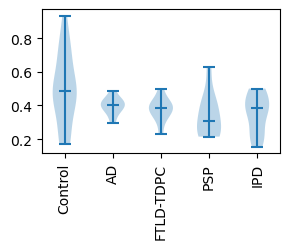

homogeneity
distance:  4
angle:  1.5707963267948966
map2


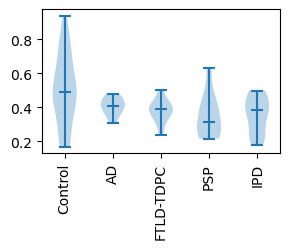

homogeneity
distance:  16
angle:  0
map2


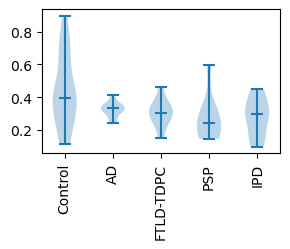

homogeneity
distance:  16
angle:  0.7853981633974483
map2


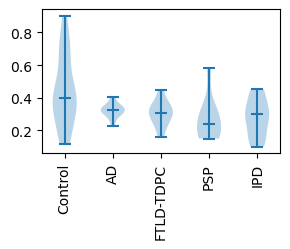

homogeneity
distance:  16
angle:  1.5707963267948966
map2


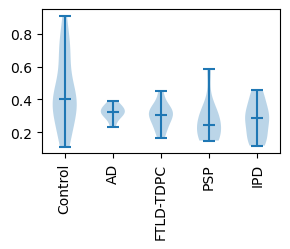

homogeneity
distance:  64
angle:  0
map2


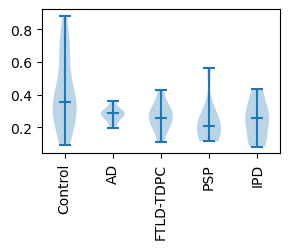

homogeneity
distance:  64
angle:  0.7853981633974483
map2


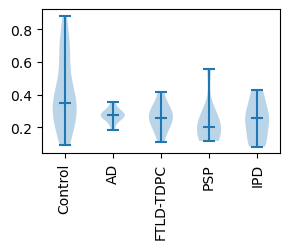

homogeneity
distance:  64
angle:  1.5707963267948966
map2


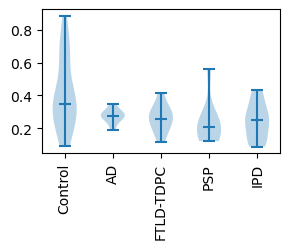

homogeneity
distance:  128
angle:  0
map2


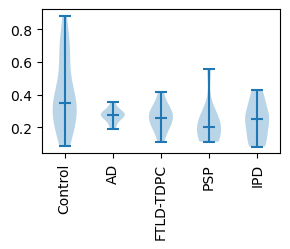

homogeneity
distance:  128
angle:  0.7853981633974483
map2


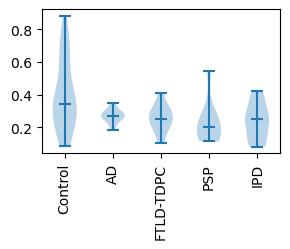

homogeneity
distance:  128
angle:  1.5707963267948966
map2


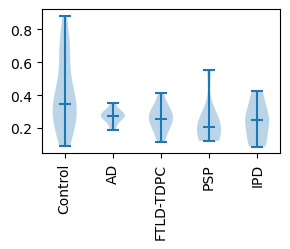

correlation
distance:  1
angle:  0
map2


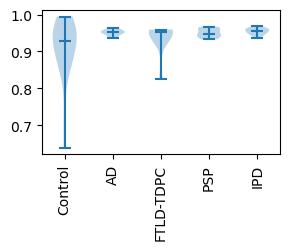

correlation
distance:  1
angle:  0.7853981633974483
map2


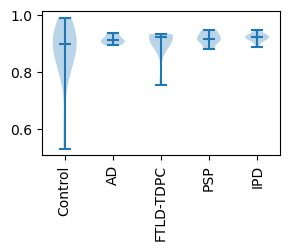

correlation
distance:  1
angle:  1.5707963267948966
map2


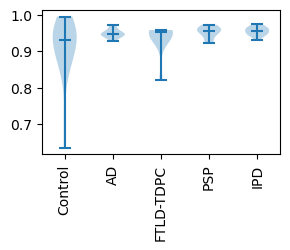

correlation
distance:  4
angle:  0
map2


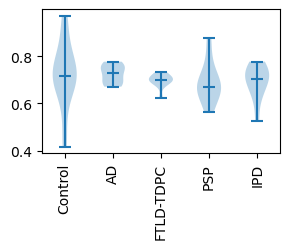

correlation
distance:  4
angle:  0.7853981633974483
map2


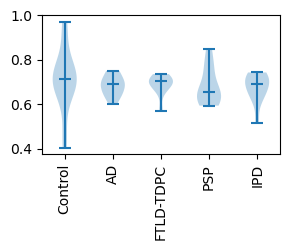

correlation
distance:  4
angle:  1.5707963267948966
map2


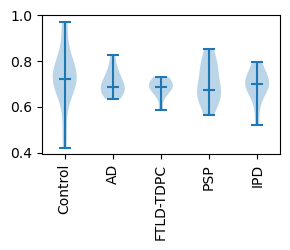

correlation
distance:  16
angle:  0
map2


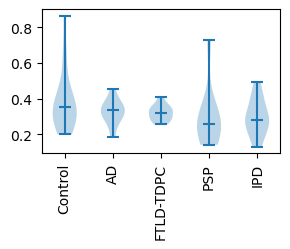

correlation
distance:  16
angle:  0.7853981633974483
map2


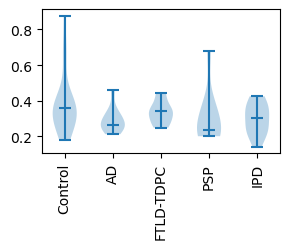

correlation
distance:  16
angle:  1.5707963267948966
map2


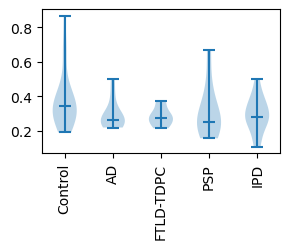

correlation
distance:  64
angle:  0
map2


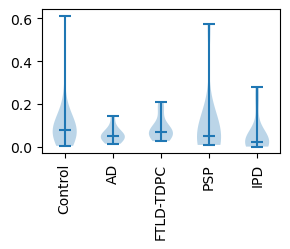

correlation
distance:  64
angle:  0.7853981633974483
map2


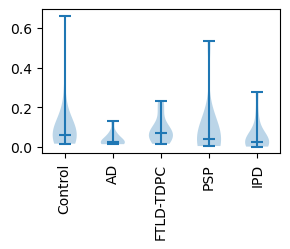

correlation
distance:  64
angle:  1.5707963267948966
map2


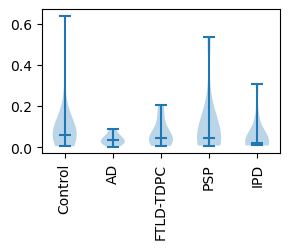

correlation
distance:  128
angle:  0
map2


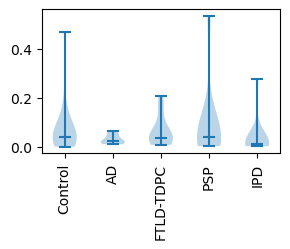

correlation
distance:  128
angle:  0.7853981633974483
map2


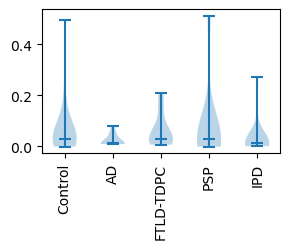

correlation
distance:  128
angle:  1.5707963267948966
map2


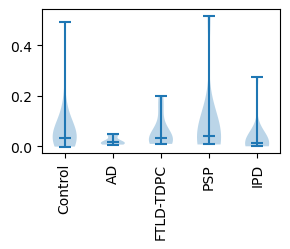

ASM
distance:  1
angle:  0
map2


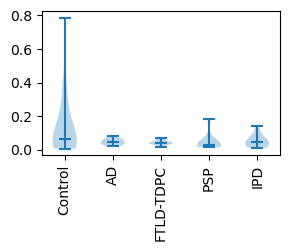

ASM
distance:  1
angle:  0.7853981633974483
map2


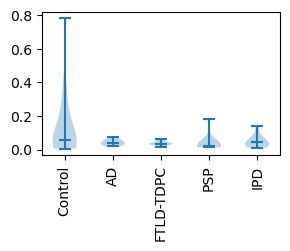

ASM
distance:  1
angle:  1.5707963267948966
map2


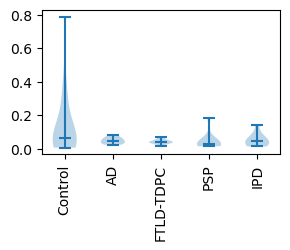

ASM
distance:  4
angle:  0
map2


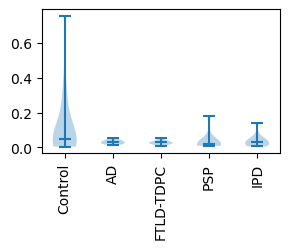

ASM
distance:  4
angle:  0.7853981633974483
map2


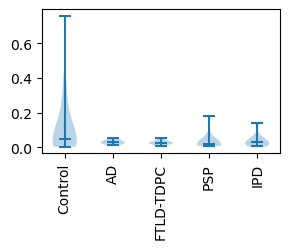

ASM
distance:  4
angle:  1.5707963267948966
map2


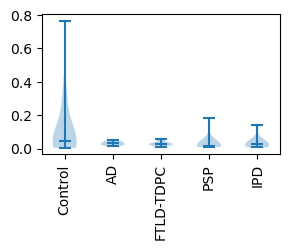

ASM
distance:  16
angle:  0
map2


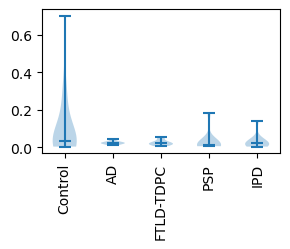

ASM
distance:  16
angle:  0.7853981633974483
map2


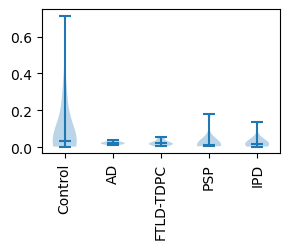

ASM
distance:  16
angle:  1.5707963267948966
map2


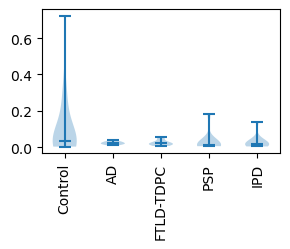

ASM
distance:  64
angle:  0
map2


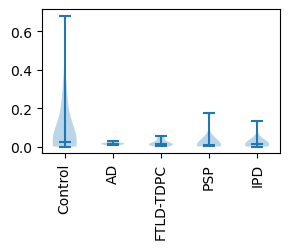

ASM
distance:  64
angle:  0.7853981633974483
map2


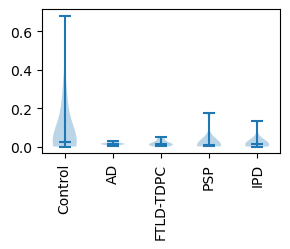

ASM
distance:  64
angle:  1.5707963267948966
map2


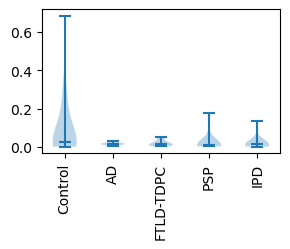

ASM
distance:  128
angle:  0
map2


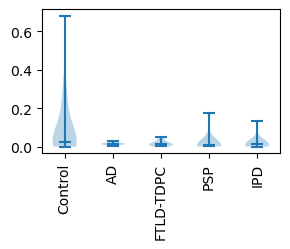

ASM
distance:  128
angle:  0.7853981633974483
map2


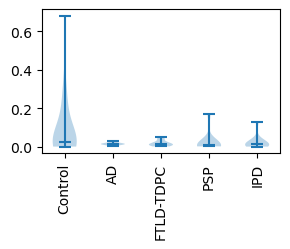

ASM
distance:  128
angle:  1.5707963267948966
map2


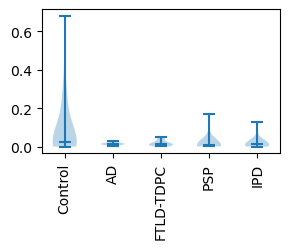

contrast
distance:  1
angle:  0
map2


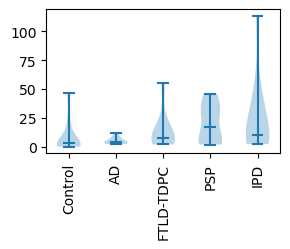

contrast
distance:  1
angle:  0.7853981633974483
map2


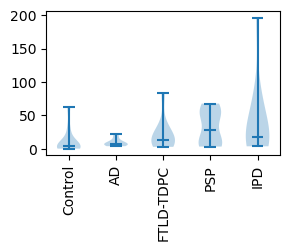

contrast
distance:  1
angle:  1.5707963267948966
map2


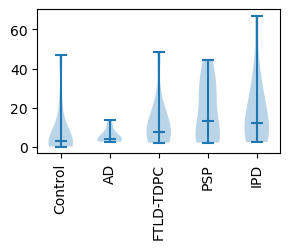

contrast
distance:  4
angle:  0
map2


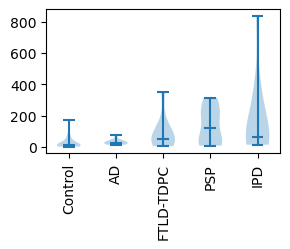

contrast
distance:  4
angle:  0.7853981633974483
map2


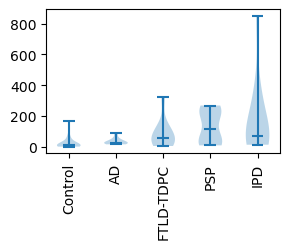

contrast
distance:  4
angle:  1.5707963267948966
map2


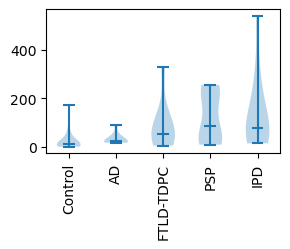

contrast
distance:  16
angle:  0
map2


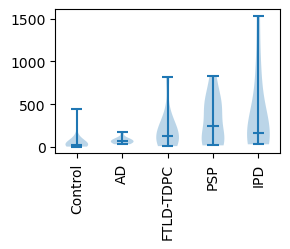

contrast
distance:  16
angle:  0.7853981633974483
map2


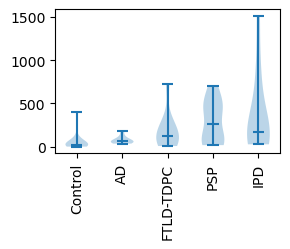

contrast
distance:  16
angle:  1.5707963267948966
map2


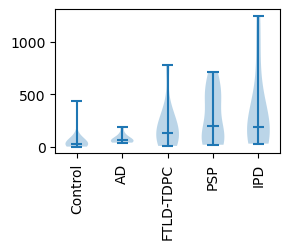

contrast
distance:  64
angle:  0
map2


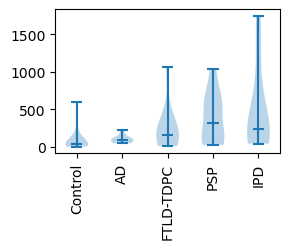

contrast
distance:  64
angle:  0.7853981633974483
map2


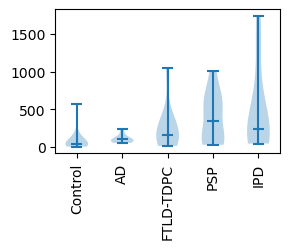

contrast
distance:  64
angle:  1.5707963267948966
map2


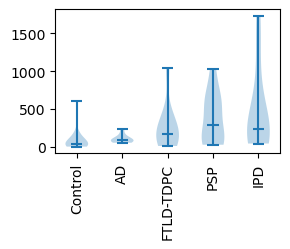

contrast
distance:  128
angle:  0
map2


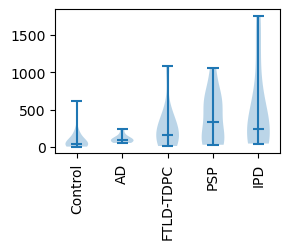

contrast
distance:  128
angle:  0.7853981633974483
map2


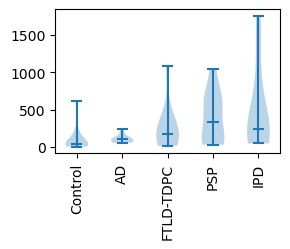

contrast
distance:  128
angle:  1.5707963267948966
map2


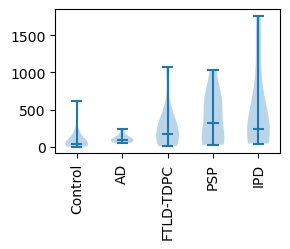

In [35]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('map2')
            prop_all={}
            for p in phenoLabels:
                prop_all[p]=[]
                for sidx in range(len(pmtx_map2[p])):
                    prop_all[p].append(feature.graycoprops(pmtx_map2[p][sidx],prop)[didx,aidx])
            
                 
            fig,ax=plt.subplots(figsize=(3,2.6))
            plt.violinplot(list(prop_all.values()), showmeans=False, showextrema=True, showmedians=True)
            plt.xticks(range(1, len(prop_all) + 1), prop_all.keys(),rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(savedir_processed,'plots',prop+'_dist'+str(distances[didx])+'_angle'+str(angles[aidx])+'_map2.pdf'))
            plt.show()
            
        

homogeneity
distance:  1
angle:  0
lmnb


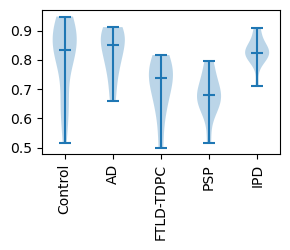

homogeneity
distance:  1
angle:  0.7853981633974483
lmnb


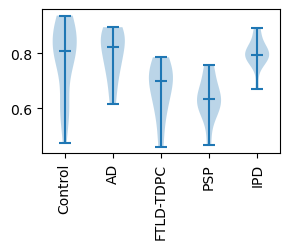

homogeneity
distance:  1
angle:  1.5707963267948966
lmnb


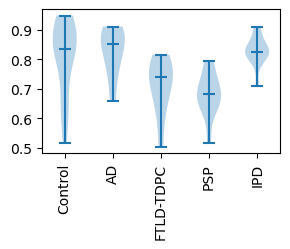

homogeneity
distance:  4
angle:  0
lmnb


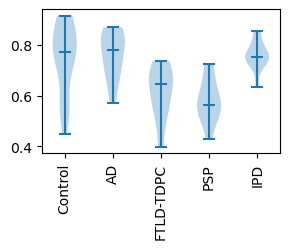

homogeneity
distance:  4
angle:  0.7853981633974483
lmnb


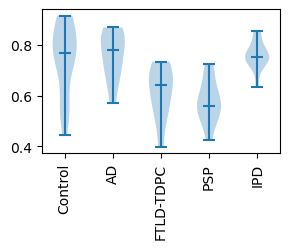

homogeneity
distance:  4
angle:  1.5707963267948966
lmnb


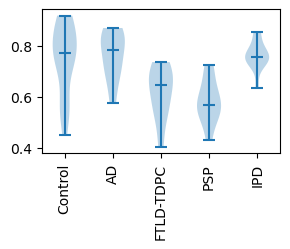

homogeneity
distance:  16
angle:  0
lmnb


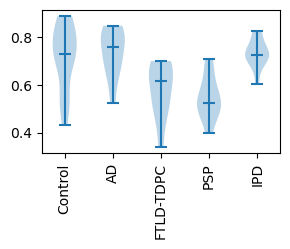

homogeneity
distance:  16
angle:  0.7853981633974483
lmnb


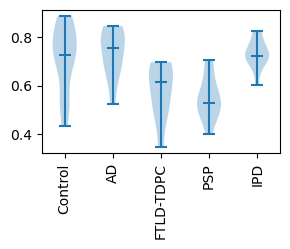

homogeneity
distance:  16
angle:  1.5707963267948966
lmnb


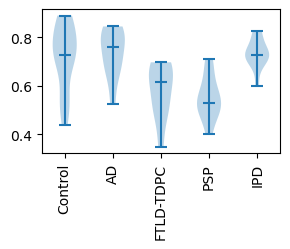

homogeneity
distance:  64
angle:  0
lmnb


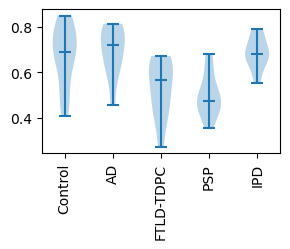

homogeneity
distance:  64
angle:  0.7853981633974483
lmnb


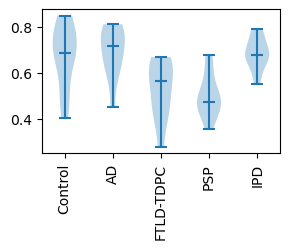

homogeneity
distance:  64
angle:  1.5707963267948966
lmnb


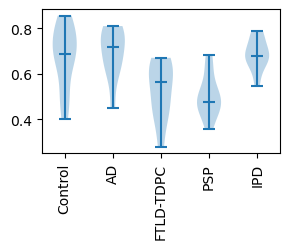

homogeneity
distance:  128
angle:  0
lmnb


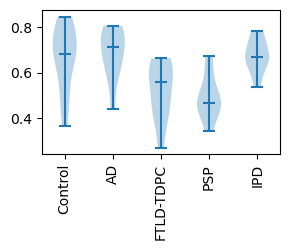

homogeneity
distance:  128
angle:  0.7853981633974483
lmnb


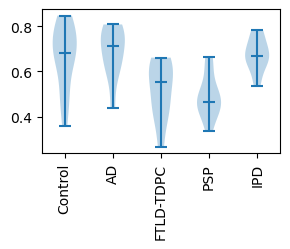

homogeneity
distance:  128
angle:  1.5707963267948966
lmnb


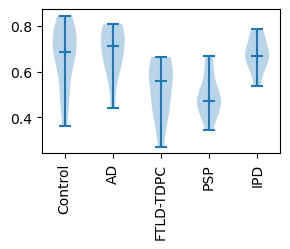

correlation
distance:  1
angle:  0
lmnb


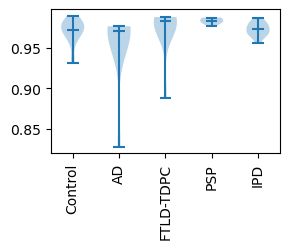

correlation
distance:  1
angle:  0.7853981633974483
lmnb


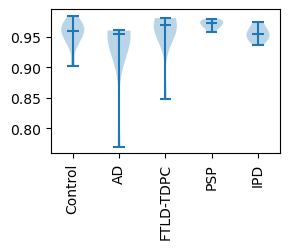

correlation
distance:  1
angle:  1.5707963267948966
lmnb


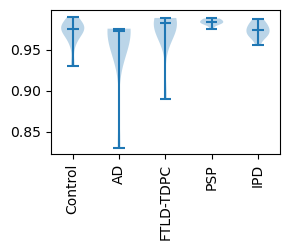

correlation
distance:  4
angle:  0
lmnb


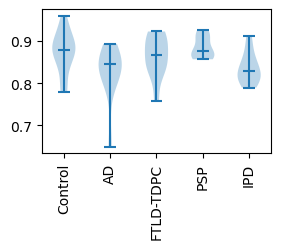

correlation
distance:  4
angle:  0.7853981633974483
lmnb


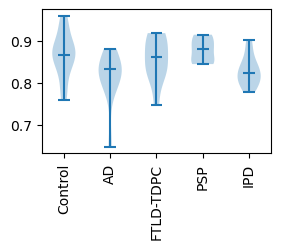

correlation
distance:  4
angle:  1.5707963267948966
lmnb


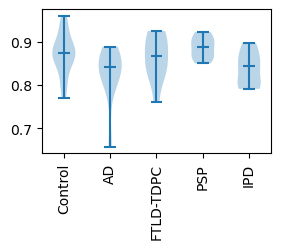

correlation
distance:  16
angle:  0
lmnb


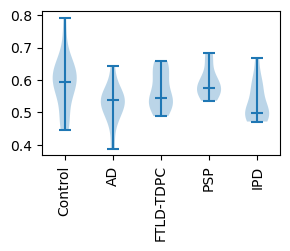

correlation
distance:  16
angle:  0.7853981633974483
lmnb


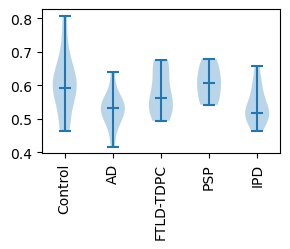

correlation
distance:  16
angle:  1.5707963267948966
lmnb


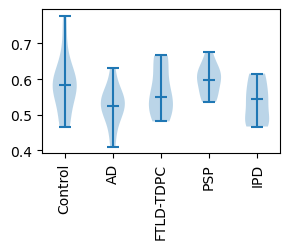

correlation
distance:  64
angle:  0
lmnb


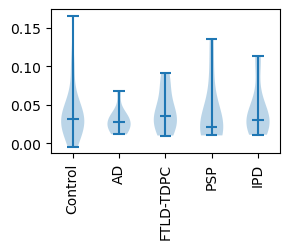

correlation
distance:  64
angle:  0.7853981633974483
lmnb


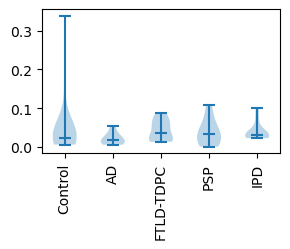

correlation
distance:  64
angle:  1.5707963267948966
lmnb


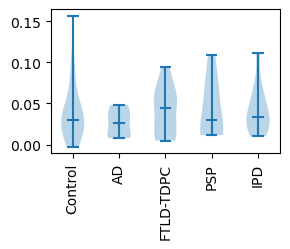

correlation
distance:  128
angle:  0
lmnb


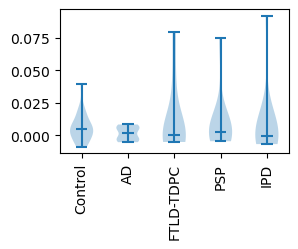

correlation
distance:  128
angle:  0.7853981633974483
lmnb


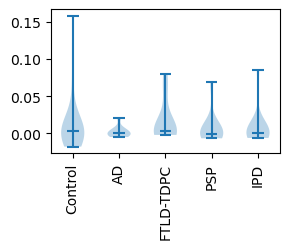

correlation
distance:  128
angle:  1.5707963267948966
lmnb


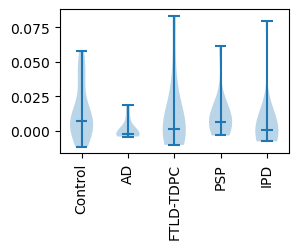

ASM
distance:  1
angle:  0
lmnb


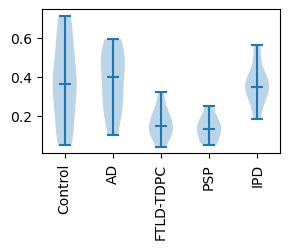

ASM
distance:  1
angle:  0.7853981633974483
lmnb


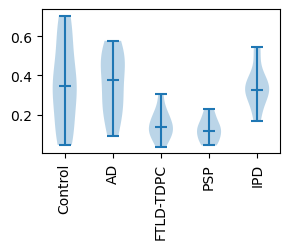

ASM
distance:  1
angle:  1.5707963267948966
lmnb


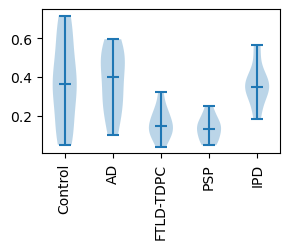

ASM
distance:  4
angle:  0
lmnb


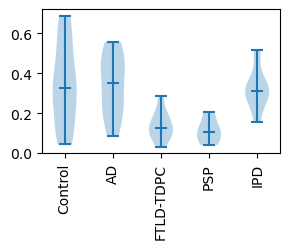

ASM
distance:  4
angle:  0.7853981633974483
lmnb


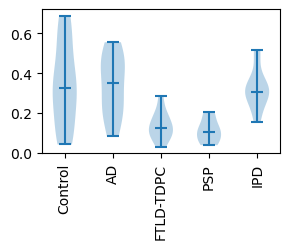

ASM
distance:  4
angle:  1.5707963267948966
lmnb


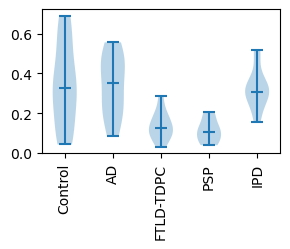

ASM
distance:  16
angle:  0
lmnb


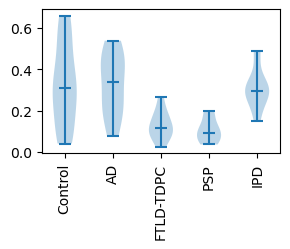

ASM
distance:  16
angle:  0.7853981633974483
lmnb


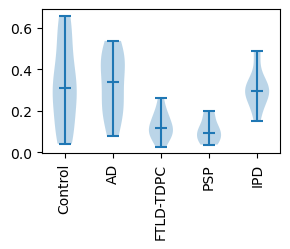

ASM
distance:  16
angle:  1.5707963267948966
lmnb


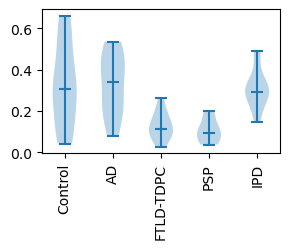

ASM
distance:  64
angle:  0
lmnb


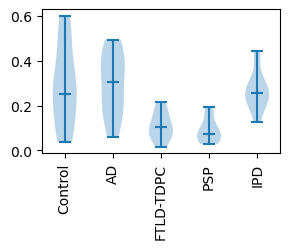

ASM
distance:  64
angle:  0.7853981633974483
lmnb


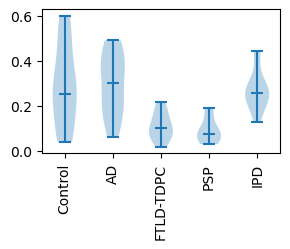

ASM
distance:  64
angle:  1.5707963267948966
lmnb


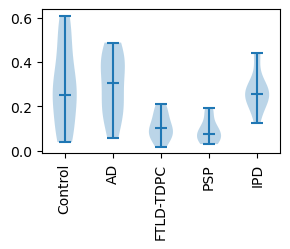

ASM
distance:  128
angle:  0
lmnb


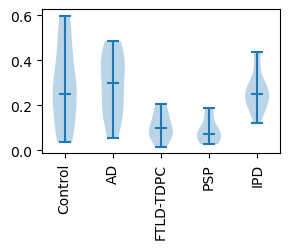

ASM
distance:  128
angle:  0.7853981633974483
lmnb


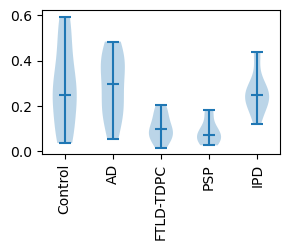

ASM
distance:  128
angle:  1.5707963267948966
lmnb


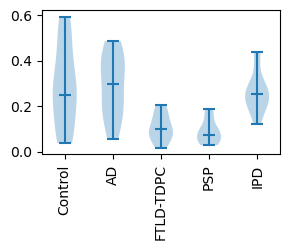

contrast
distance:  1
angle:  0
lmnb


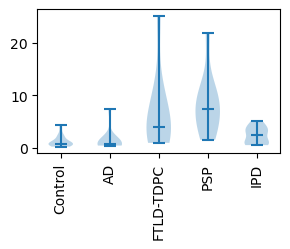

contrast
distance:  1
angle:  0.7853981633974483
lmnb


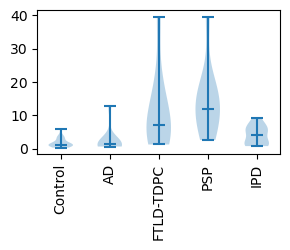

contrast
distance:  1
angle:  1.5707963267948966
lmnb


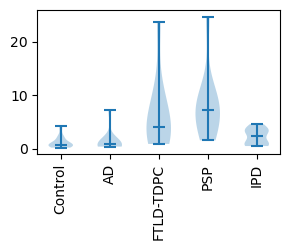

contrast
distance:  4
angle:  0
lmnb


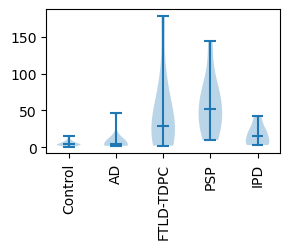

contrast
distance:  4
angle:  0.7853981633974483
lmnb


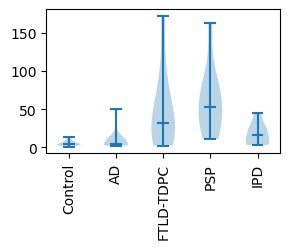

contrast
distance:  4
angle:  1.5707963267948966
lmnb


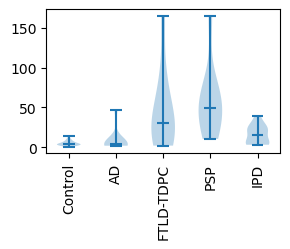

contrast
distance:  16
angle:  0
lmnb


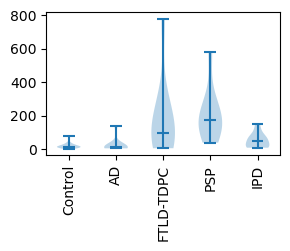

contrast
distance:  16
angle:  0.7853981633974483
lmnb


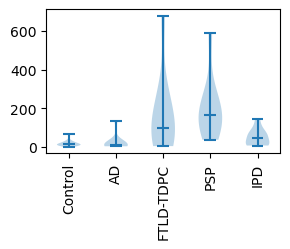

contrast
distance:  16
angle:  1.5707963267948966
lmnb


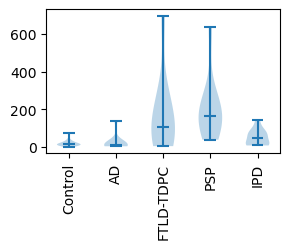

contrast
distance:  64
angle:  0
lmnb


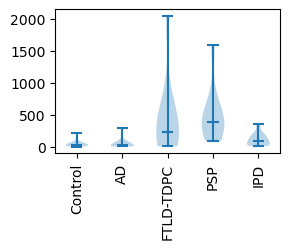

contrast
distance:  64
angle:  0.7853981633974483
lmnb


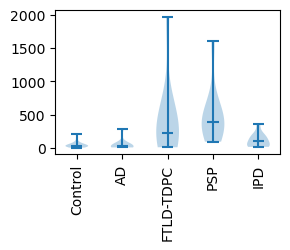

contrast
distance:  64
angle:  1.5707963267948966
lmnb


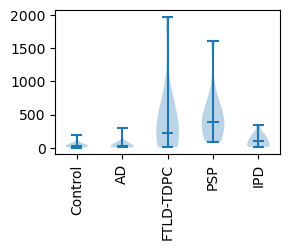

contrast
distance:  128
angle:  0
lmnb


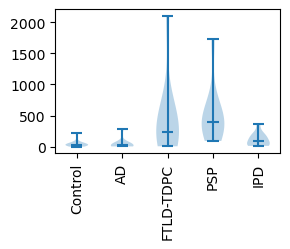

contrast
distance:  128
angle:  0.7853981633974483
lmnb


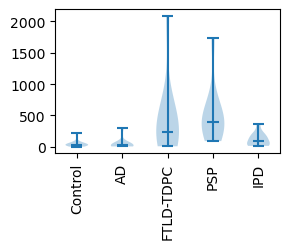

contrast
distance:  128
angle:  1.5707963267948966
lmnb


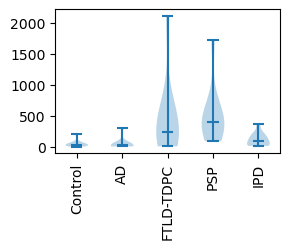

In [36]:
properties=['homogeneity','correlation','ASM','contrast']
for prop in properties:
    for didx in range(len(distances)):
        for aidx in range(len(angles)):
            print(prop)
            print('distance: ',distances[didx])
            print('angle: ',angles[aidx])
            
            print('lmnb')
            prop_all={}
            for p in phenoLabels:
                prop_all[p]=[]
                for sidx in range(len(pmtx_lmnb[p])):
                    prop_all[p].append(feature.graycoprops(pmtx_lmnb[p][sidx],prop)[didx,aidx])
            
                 
            fig,ax=plt.subplots(figsize=(3,2.6))
            plt.violinplot(list(prop_all.values()), showmeans=False, showextrema=True, showmedians=True)
            plt.xticks(range(1, len(prop_all) + 1), prop_all.keys(),rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(savedir_processed,'plots',prop+'_dist'+str(distances[didx])+'_angle'+str(angles[aidx])+'_lmnb.pdf'))
            plt.show()
            
        